In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; 
# warnings.filterwarnings('ignore')

import os
import sys
sys.path.append(os.path.abspath('../'))
import abupy
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

only use pandas calc nd, please install talib!
enable example env will only read RomDataBu/df_kl.h5


In [2]:
print(sys.version)

3.6.0 |Anaconda 4.3.1 (x86_64)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


# 第10章 量化系统-机器学习•猪老三 

## 10.2 猪老三世界中的量化环境

In [2]:
"""
    是否开启date_week噪音, 开启这个的目的是让分类结果正确率降低，接近真实
"""
g_with_date_week_noise = False

In [3]:
from abupy import ABuSymbolPd

def _gen_another_word_price(kl_another_word):
    """
    生成股票在另一个世界中的价格
    :param kl_another_word:
    :return:
    """
    for ind in np.arange(2, kl_another_word.shape[0]):
        # 前天数据
        bf_yesterday = kl_another_word.iloc[ind - 2]
        # 昨天
        yesterday = kl_another_word.iloc[ind - 1]
        # 今天
        today = kl_another_word.iloc[ind]
        # 生成今天的收盘价格
        kl_another_word.close[ind] = _gen_another_word_price_rule(
            yesterday.close, yesterday.volume,
            bf_yesterday.close, bf_yesterday.volume,
            today.volume, today.date_week)


def _gen_another_word_price_rule(yesterday_close, yesterday_volume,
                                 bf_yesterday_close,
                                 bf_yesterday_volume,
                                 today_volume, date_week):
    """
        通过前天收盘量价，昨天收盘量价，今天的量，构建另一个世界中的价格模型
    """
    # 昨天收盘价格与前天收盘价格的价格差
    price_change = yesterday_close - bf_yesterday_close
    # 昨天成交量与前天成交量的量差
    volume_change = yesterday_volume - bf_yesterday_volume

    # 如果量和价变动一致，今天价格涨，否则跌
    # 即量价齐涨－>涨, 量价齐跌－>涨，量价不一致－>跌
    sign = 1.0 if price_change * volume_change > 0 else -1.0
    
    # 通过date_week生成噪音，否则之后分类100%分对
    if g_with_date_week_noise:
        # 针对sign生成噪音，噪音的生效的先决条件是今天的量是这三天最大的
        gen_noise = today_volume > np.max(
            [yesterday_volume, bf_yesterday_volume])
        # 如果量是这三天最大 且是周五，下跌
        if gen_noise and date_week == 4:
            sign = -1.0
        # 如果量是这三天最大，如果是周一，上涨
        elif gen_noise and date_week == 0:
            sign = 1.0

    # 今天的涨跌幅度基础是price_change（昨天前天的价格变动）
    price_base = abs(price_change)
    # 今天的涨跌幅度变动因素：量比，
    # 今天的成交量/昨天的成交量 和 今天的成交量/前天的成交量 的均值
    price_factor = np.mean([today_volume / yesterday_volume,
                            today_volume / bf_yesterday_volume])

    if abs(price_base * price_factor) < yesterday_close * 0.10:
        # 如果 量比 * price_base 没超过10%，今天价格计算
        today_price = yesterday_close + \
                      sign * price_base * price_factor
    else:
        # 如果涨跌幅度超过10%，限制上限，下限为10%
        today_price = yesterday_close + sign * yesterday_close * 0.10
    return today_price


def change_real_to_another_word(symbol):
    """
    将原始真正的股票数据价格列只保留前两天数据，成交量，周几列完全保留
    价格列其他数据使用_gen_another_word_price变成另一个世界价格
    :param symbol:
    :return:
    """
    kl_pd = ABuSymbolPd.make_kl_df(symbol)
    if kl_pd is not None:
        # 原始股票数据也只保留价格，周几，成交量
        kl_pig_three = kl_pd.filter(['close', 'date_week', 'volume'])
        # 只保留原始头两天的交易收盘价格，其他的的都赋予nan
        kl_pig_three['close'][2:] = np.nan
        # 将其他nan价格变成猪老三世界中价格使用_gen_another_word_price
        _gen_another_word_price(kl_pig_three)
        return kl_pig_three

In [4]:
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS']
another_word_dict = {}
real_dict = {}
for symbol in choice_symbols:
    # 猪老三世界的股票走势字典
    another_word_dict[symbol] = change_real_to_another_word(symbol)
    # 真实世界的股票走势字典，这里不考虑运行效率问题
    real_dict[symbol] = ABuSymbolPd.make_kl_df(symbol)
# 表10-1所示
another_word_dict['usNOAH'].head()

,close,date_week,volume
2014-07-24,15.210000,3,307211
2014-07-25,15.320000,4,101442
2014-07-28,14.886142,0,601568
2014-07-29,13.397528,1,655297
2014-07-30,12.570869,2,348344


In [6]:
# 表10-2所示
real_dict['usNOAH'].head().filter(['close', 'date_week', 'volume'])

,close,date_week,volume
2014-07-24,15.21,3,307211
2014-07-25,15.32,4,101442
2014-07-28,16.13,0,601568
2014-07-29,16.75,1,655297
2014-07-30,16.83,2,348344


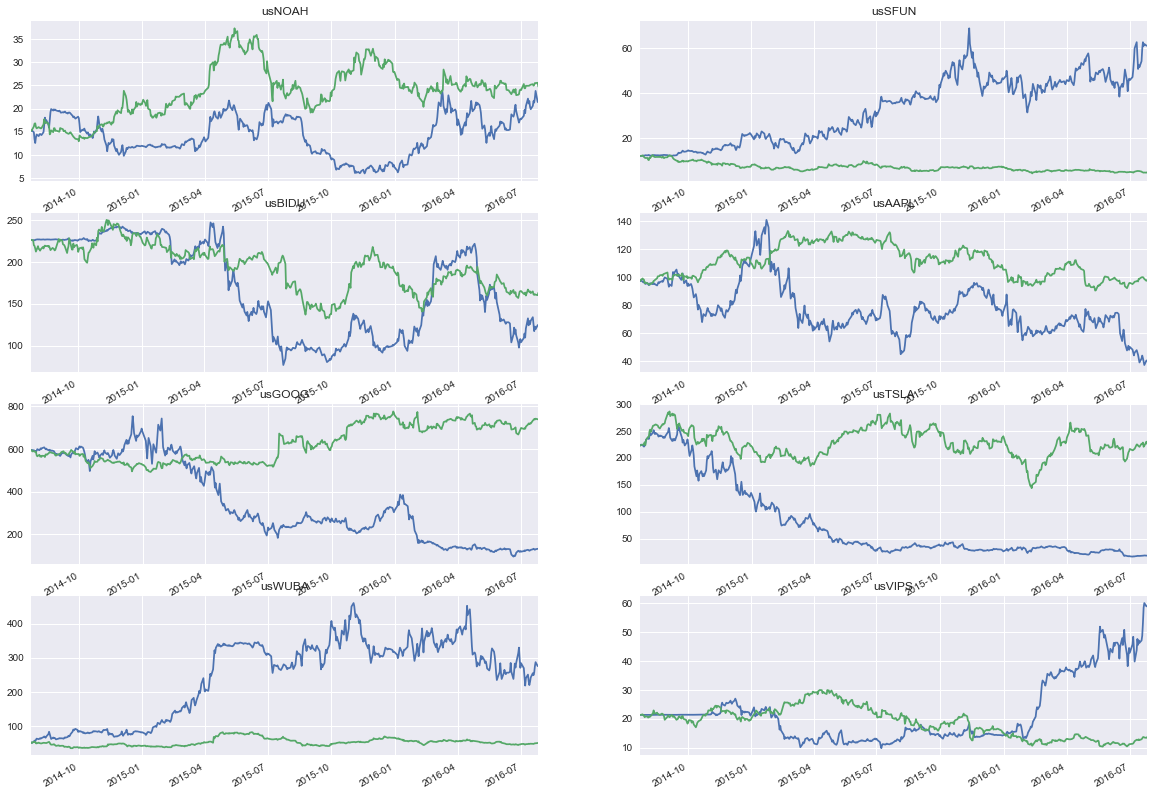

In [7]:
import itertools
# 4 ＊ 2
_, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
# 将画布序列拉平
axs_list = list(itertools.chain.from_iterable(axs))

for symbol, ax in zip(choice_symbols, axs_list):
    # 绘制猪老三世界的股价走势
    another_word_dict[symbol].close.plot(ax=ax)
    # 同样的股票在真实世界的股价走势
    real_dict[symbol].close.plot(ax=ax)
    ax.set_title(symbol)

## 10.3 有监督机器学习

In [5]:
import sklearn.preprocessing as preprocessing

def gen_pig_three_feature(kl_another_word):
    """
    猪老三构建特征模型函数
    :param kl_another_word: 即上一节使用_gen_another_word_price
    生成的dataframe有收盘价，周几，成交量列
    :return:
    """
    # y值使用close.pct_change即涨跌幅度
    kl_another_word['regress_y'] = kl_another_word.close.pct_change()
    # 前天收盘价格
    kl_another_word['bf_yesterday_close'] = 0
    # 昨天收盘价格
    kl_another_word['yesterday_close'] = 0
    # 昨天收盘成交量
    kl_another_word['yesterday_volume'] = 0
    # 前天收盘成交量
    kl_another_word['bf_yesterday_volume'] = 0

    # 对齐特征，前天收盘价格即与今天的收盘错2个时间单位，[2:] = [:-2]
    kl_another_word['bf_yesterday_close'][2:] = \
        kl_another_word['close'][:-2]
    # 对齐特征，前天成交量
    kl_another_word['bf_yesterday_volume'][2:] = \
        kl_another_word['volume'][:-2]
    # 对齐特征，昨天收盘价与今天的收盘错1个时间单位，[1:] = [:-1]
    kl_another_word['yesterday_close'][1:] = \
        kl_another_word['close'][:-1]
    # 对齐特征，昨天成交量
    kl_another_word['yesterday_volume'][1:] = \
        kl_another_word['volume'][:-1]

    # 特征1: 价格差
    kl_another_word['feature_price_change'] = \
        kl_another_word['yesterday_close'] - \
        kl_another_word['bf_yesterday_close']

    # 特征2: 成交量差
    kl_another_word['feature_volume_Change'] = \
        kl_another_word['yesterday_volume'] - \
        kl_another_word['bf_yesterday_volume']

    # 特征3: 涨跌sign
    kl_another_word['feature_sign'] = np.sign(
        kl_another_word['feature_price_change'] * kl_another_word[
            'feature_volume_Change'])

    # 特征4: 周几
    kl_another_word['feature_date_week'] = kl_another_word[
        'date_week']


    """
        构建噪音特征, 因为猪老三也不可能全部分析正确真实的特征因素
        这里引入一些噪音特征
    """
    # 成交量乘积
    kl_another_word['feature_volume_noise'] = \
        kl_another_word['yesterday_volume'] * \
        kl_another_word['bf_yesterday_volume']

    # 价格乘积
    kl_another_word['feature_price_noise'] = \
        kl_another_word['yesterday_close'] * \
        kl_another_word['bf_yesterday_close']

    # 将数据标准化
    scaler = preprocessing.StandardScaler()
    kl_another_word['feature_price_change'] = scaler.fit_transform(
        kl_another_word['feature_price_change'].values.reshape(-1, 1))
    kl_another_word['feature_volume_Change'] = scaler.fit_transform(
        kl_another_word['feature_volume_Change'].values.reshape(-1, 1))
    kl_another_word['feature_volume_noise'] = scaler.fit_transform(
        kl_another_word['feature_volume_noise'].values.reshape(-1, 1))
    kl_another_word['feature_price_noise'] = scaler.fit_transform(
        kl_another_word['feature_price_noise'].values.reshape(-1, 1))

    # 只筛选feature_开头的特征和regress_y，抛弃前两天数据，即[2:]
    kl_pig_three_feature = kl_another_word.filter(
        regex='regress_y|feature_*')[2:]
    return kl_pig_three_feature

In [6]:
pig_three_feature = None
for symbol in another_word_dict:
    # 首先拿出对应的走势数据
    kl_another_word = another_word_dict[symbol]
    # 通过走势数据生成训练集特征通过gen_pig_three_feature
    kl_feature = gen_pig_three_feature(kl_another_word)
    # 将每个股票的特征数据都拼接起来，形成训练集
    pig_three_feature = kl_feature if pig_three_feature is None \
        else pig_three_feature.append(kl_feature)

/Users/Bailey/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
print(pig_three_feature.shape)
# 表10-3所示
pig_three_feature.tail()

(4016, 7)


,regress_y,feature_price_change,feature_volume_Change,feature_sign,feature_date_week,feature_volume_noise,feature_price_noise
2016-07-20,0.089265,1.050627,0.313388,1.0,2,-0.224892,2.670004
2016-07-21,0.100000,2.909614,0.663575,1.0,3,-0.136784,3.129855
2016-07-22,0.028320,3.568204,0.245241,1.0,4,0.020137,3.936763
2016-07-25,-0.018584,1.056225,-1.169929,-1.0,0,-0.166979,4.576557
2016-07-26,-0.000533,-0.847329,0.022124,-1.0,1,-0.233479,4.627377


### 10.3.1 猪老三使用回归预测股价

In [8]:
# Dataframe -> matrix
feature_np = pig_three_feature.as_matrix()
# x特征矩阵
train_x = feature_np[:, 1:]
# 回归训练的连续值y
train_y_regress = feature_np[:, 0]
# 分类训练的离散值y，之后分类技术使用
train_y_classification = np.where(train_y_regress > 0, 1, 0)

train_x[:5], train_y_regress[:5], train_y_classification[:5]

(array([[ 0.06564644, -0.60426213, -1.        ,  0.        , -0.3771742 ,
          0.08429528],
        [-0.4634593 ,  1.46417121, -1.        ,  1.        , -0.33967997,
          0.04383694],
        [-1.48960523,  0.15612619, -1.        ,  2.        ,  0.07868286,
         -0.18952875],
        [-0.84560529, -0.90075433,  1.        ,  3.        , -0.12967761,
         -0.44247116],
        [ 1.12475764,  0.91065113,  1.        ,  4.        , -0.12780859,
         -0.40433982]]),
 array([-0.02831971, -0.1       , -0.06170233,  0.09535066,  0.04593096]),
 array([0, 0, 0, 1, 1]))

In [9]:
def gen_feature_from_symbol(symbol):
    """
    封装由一个symbol转换为特征矩阵序列函数
    :param symbol:
    :return:
    """
    # 真实世界走势数据转换到老三的世界
    kl_another_word = change_real_to_another_word(symbol)
    # 由走势转换为特征dataframe通过gen_pig_three_feature
    kl_another_word_feature_test = \
        gen_pig_three_feature(kl_another_word)
    # 转换为matrix
    feature_np_test = kl_another_word_feature_test.as_matrix()
    # 从matrix抽取y回归
    test_y_regress = feature_np_test[:, 0]
    # y回归 －> y分类
    test_y_classification = np.where(test_y_regress > 0, 1, 0)
    # 从matrix抽取x特征矩阵
    test_x = feature_np_test[:, 1:]
    return test_x, test_y_regress, test_y_classification, \
           kl_another_word_feature_test

test_x, test_y_regress, test_y_classification, \
    kl_another_word_feature_test = gen_feature_from_symbol('usFB')

/Users/Bailey/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


LinearRegression RMSE: 0.02600833519357202


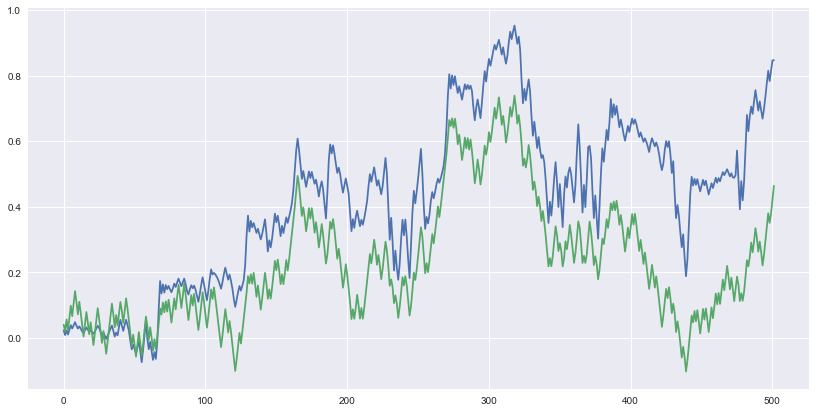

In [10]:
from sklearn.linear_model import LinearRegression
from abupy import cross_val_score
from abupy.CoreBu.ABuFixes import mean_squared_error_scorer


def regress_process(estimator, train_x, train_y_regress, test_x,
                    test_y_regress):
    # 训练训练集数据
    estimator.fit(train_x, train_y_regress)
    # 使用训练好的模型预测测试集对应的y，即根据usFB的走势特征预测股价涨跌幅度
    test_y_prdict_regress = estimator.predict(test_x)

    # 绘制usFB实际股价涨跌幅度
    plt.plot(test_y_regress.cumsum())
    # 绘制通过模型预测的usFB股价涨跌幅度
    plt.plot(test_y_prdict_regress.cumsum())

    # 针对训练集数据做交叉验证
    scores = cross_val_score(estimator, train_x, train_y_regress, cv=10, scoring=mean_squared_error_scorer)
    # mse开方 -> rmse
    mean_sc = -np.mean(np.sqrt(-scores))
    print('{} RMSE: {}'.format(estimator.__class__.__name__, mean_sc))


# 实例化线性回归对象estimator
estimator = LinearRegression()
# 将回归模型对象，训练集x，训练集连续y值，测试集x，测试集连续y传入
regress_process(estimator, train_x, train_y_regress, test_x,
                test_y_regress)

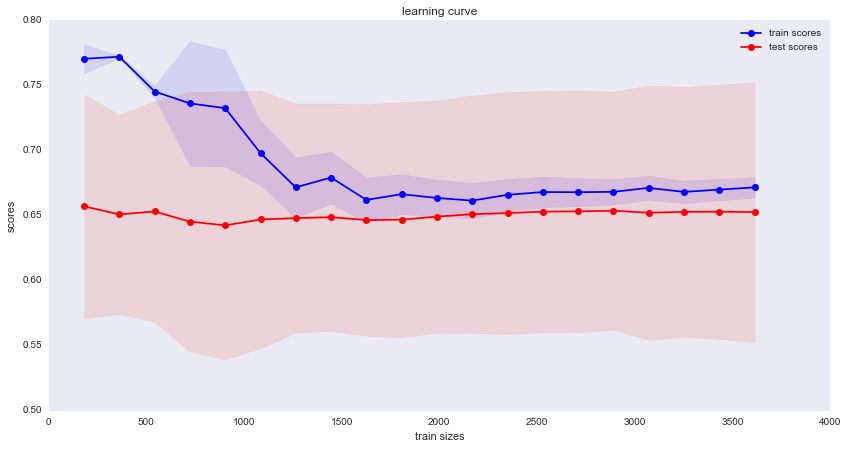

In [60]:
from abupy import ABuMLExecute
ABuMLExecute.plot_learning_curve(estimator, train_x, train_y_regress, cv=10)

Pipeline RMSE: 0.02444074685661411


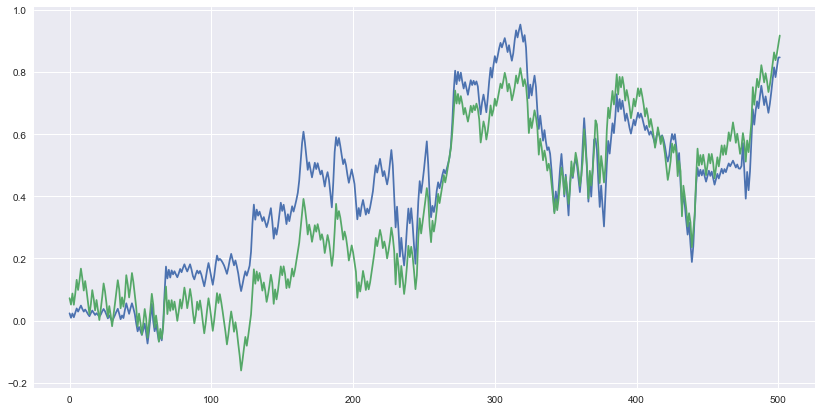

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# pipeline套上 degree=3 ＋ LinearRegression
estimator = make_pipeline(PolynomialFeatures(degree=3),
                          LinearRegression())
# 继续使用regress_process，区别是estimator变了
regress_process(estimator, train_x, train_y_regress, test_x,
                test_y_regress)

AdaBoostRegressor RMSE: 0.023937006779812052


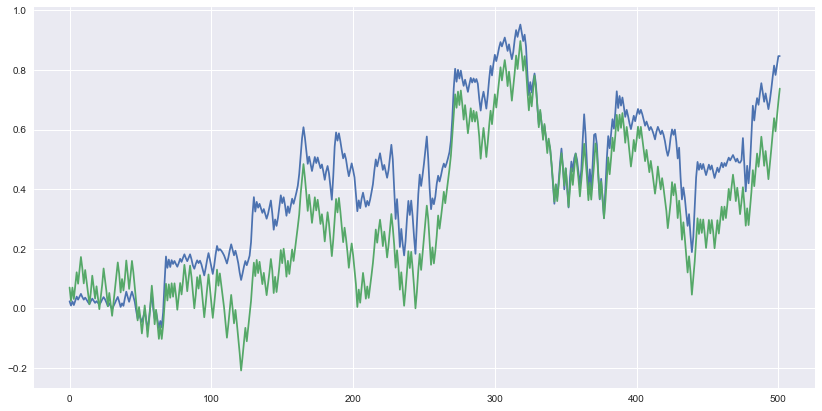

In [13]:
from sklearn.ensemble import AdaBoostRegressor

estimator = AdaBoostRegressor(n_estimators=100)
regress_process(estimator, train_x, train_y_regress, test_x,
                test_y_regress)

RandomForestRegressor RMSE: 0.019910227471184785


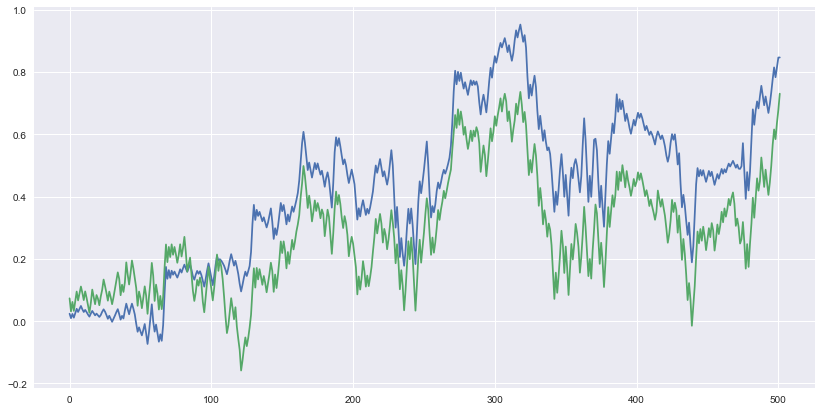

In [14]:
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor(n_estimators=100)
regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress)

### 10.3.2 猪老三使用分类预测股票涨跌

#### 如果不添加噪音，分类预测正确率将是100%

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


def classification_process(estimator, train_x, train_y_classification,
                           test_x, test_y_classification):
    # 训练数据，这里分类要所以要使用y_classification
    estimator.fit(train_x, train_y_classification)
    # 使用训练好的分类模型预测测试集对应的y，即根据usFB的走势特征预测涨跌
    test_y_prdict_classification = estimator.predict(test_x)
    # 通过metrics.accuracy_score度量预测涨跌的准确率
    print("{} accuracy = {:.2f}".format(
        estimator.__class__.__name__,
        metrics.accuracy_score(test_y_classification,
                               test_y_prdict_classification)))

    # 针对训练集数据做交叉验证scoring='accuracy'，cv＝10
    scores = cross_val_score(estimator, train_x,
                             train_y_classification,
                             cv=10,
                             scoring='accuracy')
    # 所有交叉验证的分数取平均值
    mean_sc = np.mean(scores)
    print('cross validation accuracy mean: {:.2f}'.format(mean_sc))


estimator = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# 将分类器，训练集x，训练集y分类，测试集，测试集y分别传入函数
classification_process(estimator, train_x, train_y_classification,
                       test_x, test_y_classification)

LogisticRegression accuracy = 1.00
cross validation accuracy mean: 1.00


## 1.0 将g_with_date_week_noise = True 添加噪音后重现生成数据

In [12]:
g_with_date_week_noise = True

choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usTSLA', 'usWUBA', 'usVIPS']
another_word_dict = {}
real_dict = {}
for symbol in choice_symbols:
    another_word_dict[symbol] = change_real_to_another_word(symbol)
    real_dict[symbol] = ABuSymbolPd.make_kl_df(symbol)
pig_three_feature = None
for symbol in another_word_dict:
    kl_another_word = another_word_dict[symbol]
    kl_feature = gen_pig_three_feature(kl_another_word)
    pig_three_feature = kl_feature if pig_three_feature is None else pig_three_feature.append(kl_feature)

feature_np = pig_three_feature.as_matrix()
train_x = feature_np[:, 1:]
train_y_regress = feature_np[:, 0]
train_y_classification = np.where(train_y_regress > 0, 1, 0)
train_x[:5], train_y_regress[:5], train_y_classification[:5]
test_x, test_y_regress, test_y_classification, kl_another_word_feature_test = gen_feature_from_symbol('usFB')

/Users/Bailey/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## noise 0.93

In [13]:
estimator = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification)

LogisticRegression accuracy = 0.93
cross validation accuracy mean: 0.92


In [18]:
from sklearn.svm import SVC

estimator = SVC(kernel='rbf')
classification_process(estimator, train_x, train_y_classification,
                       test_x, test_y_classification)

SVC accuracy = 0.94
cross validation accuracy mean: 0.92


In [14]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)
classification_process(estimator, train_x, train_y_classification,
                       test_x, test_y_classification)

RandomForestClassifier accuracy = 0.93
cross validation accuracy mean: 0.92


## train_test_split

In [15]:
from abupy import train_test_split


def train_test_split_xy(estimator, x, y, test_size=0.5,
                        random_state=0):
    # 通过train_test_split将原始训练集随机切割为新训练集与测试集
    train_x, test_x, train_y, test_y = \
        train_test_split(x, y, test_size=test_size,
                         random_state=random_state)

    print(x.shape, y.shape)
    print(train_x.shape, train_y.shape)
    print(test_x.shape, test_y.shape)

    clf = estimator.fit(train_x, train_y)
    predictions = clf.predict(test_x)

    # 度量准确率
    print("accuracy = %.2f" % 
          (metrics.accuracy_score(test_y, predictions)))
    
    # 度量查准率
    print("precision_score = %.2f" % 
          (metrics.precision_score(test_y, predictions)))
    
    # 度量回收率
    print("recall_score = %.2f" % 
          (metrics.recall_score(test_y, predictions)))

    return test_y, predictions


test_y, predictions = train_test_split_xy(estimator, train_x,
                                          train_y_classification)

(4016, 6) (4016,)
(2008, 6) (2008,)
(2008, 6) (2008,)
accuracy = 0.92
precision_score = 0.93
recall_score = 0.91


## 混淆矩阵和roc曲线

In [21]:
def confusion_matrix_with_report(test_y, predictions):
    confusion_matrix = metrics.confusion_matrix(test_y, predictions)
    # print("Confusion Matrix ", confusion_matrix)
    print("          Predicted")
    print("         |  0  |  1  |")
    print("         |-----|-----|")
    print("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                      confusion_matrix[0, 1]))
    print("Actual   |-----|-----|")
    print("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                      confusion_matrix[1, 1]))
    print("         |-----|-----|")

    print(metrics.classification_report(test_y, predictions))
    

confusion_matrix_with_report(test_y, predictions)

          Predicted
         |  0  |  1  |
         |-----|-----|
       0 | 908 |  71 |
Actual   |-----|-----|
       1 |  99 | 930 |
         |-----|-----|
             precision    recall  f1-score   support

          0       0.90      0.93      0.91       979
          1       0.93      0.90      0.92      1029

avg / total       0.92      0.92      0.92      2008



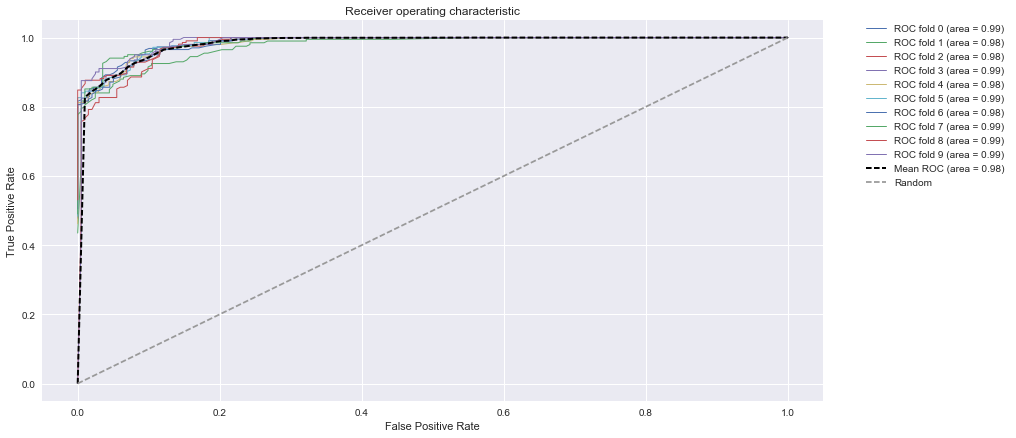

In [16]:
from abupy import ABuMLExecute
ABuMLExecute.plot_roc_estimator(estimator, train_x, train_y_classification)

### 10.3.3 通过决策树分类，绘制出决策图

这里需要安装dot graphviz，才能通过os.system("dot -T png graphviz.dot -o graphviz.png")生成png

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os

estimator = DecisionTreeClassifier(max_depth=2, random_state=1)


def graphviz_tree(estimator, features, x, y):
    if not hasattr(estimator, 'tree_'):
        print('only tree can graphviz!')
        return

    estimator.fit(x, y)
    # 将决策模型导出graphviz.dot文件
    tree.export_graphviz(estimator.tree_, out_file='graphviz.dot',
                         feature_names=features)
    # 通过dot将模型绘制决策图，保存png
    os.system("dot -T png graphviz.dot -o graphviz.png")
# 这里会使用到特征的名称列pig_three_feature.columns[1:]
graphviz_tree(estimator, pig_three_feature.columns[1:], train_x,
              train_y_classification)

! open graphviz.png

## 特征的重要性排序及支持度评级

In [40]:
def importances_coef_pd(estimator):
    if hasattr(estimator, 'feature_importances_'):
        # 有feature_importances_的通过sort_values排序
        return pd.DataFrame(
            {'feature': list(pig_three_feature.columns[1:]),
            'importance': estimator.feature_importances_}).sort_values(
            'importance')

    elif hasattr(estimator, 'coef_'):
        # 有coef_的通过coef排序
        return pd.DataFrame(
            {"columns": list(pig_three_feature.columns)[1:],
             "coef": list(estimator.coef_.T)}).sort_values(
            'coef')
    else:
        print('estimator not hasattr feature_importances_ or coef_!')

# 使用随机森林分类器
estimator = RandomForestClassifier(n_estimators=100)
# 训练数据模型
estimator.fit(train_x, train_y_classification)
# 对训练后的模型特征的重要度进行判定，重要程度由小到大，表10-4所示
importances_coef_pd(estimator)

,feature,importance
5,feature_price_noise,0.049542
4,feature_volume_noise,0.052699
0,feature_price_change,0.086455
1,feature_volume_Change,0.090927
3,feature_date_week,0.093496
2,feature_sign,0.626882


In [28]:
from sklearn.feature_selection import RFE


def feature_selection(estimator, x, y):
    selector = RFE(estimator)
    selector.fit(x, y)
    print('RFE selection')
    print(pd.DataFrame(
        {'support': selector.support_, 'ranking': selector.ranking_},
        index=pig_three_feature.columns[1:]))


feature_selection(estimator, train_x, train_y_classification)

RFE selection
                       ranking support
feature_price_change         1    True
feature_volume_Change        1    True
feature_sign                 1    True
feature_date_week            2   False
feature_volume_noise         3   False
feature_price_noise          4   False


## 10.4 无监督机器学习

### 10.4.1 使用降维可视化数据

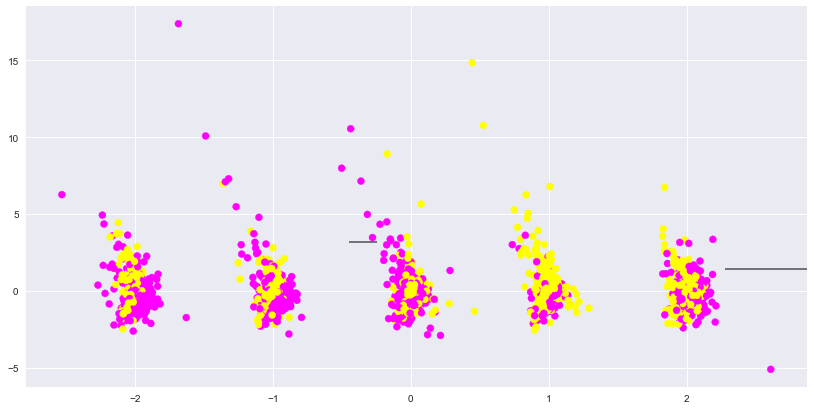

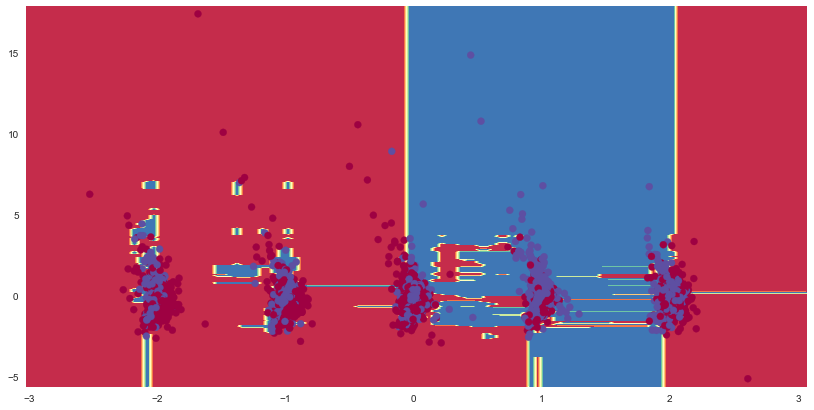

In [19]:
from sklearn.decomposition import PCA


def plot_decision_function(estimator, x, y):
    # pca进行降维，只保留2个特征序列
    pca_2n = PCA(n_components=2)
    x = pca_2n.fit_transform(x)

    # 进行训练
    estimator.fit(x, y)
    plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='spring')
    ABuMLExecute.plot_decision_function(estimator)
    ABuMLExecute.plot_decision_boundary(
        lambda p_x: estimator.predict(p_x), x, y)


estimator = RandomForestClassifier(n_estimators=100)
plot_decision_function(estimator, train_x, train_y_classification)

### 10.4.2 猪老三使用聚类算法提高正确率

In [21]:
# 使用随机森林作为分类器
estimator = RandomForestClassifier(n_estimators=100)
estimator.fit(train_x, train_y_classification)
test_y_prdict_classification = estimator.predict(test_x)

print("accuracy = %.2f" % (
metrics.accuracy_score(test_y_classification,
                       test_y_prdict_classification)))

accuracy = 0.93


In [22]:
# 测试集feature即usFB的kl feature
pig_three_kmean_feature = kl_another_word_feature_test
# 测试集真实的涨跌结果test_y_classification
pig_three_kmean_feature['y'] = test_y_classification
# 使用刚刚的随机森林作为分类器的预测涨跌结果test_y_prdict_classification
pig_three_kmean_feature['y_prdict'] = test_y_prdict_classification
# 即生成一列新数据记录预测是否正确
pig_three_kmean_feature['y_same'] = np.where(
    pig_three_kmean_feature['y'] ==
    pig_three_kmean_feature['y_prdict'], 1, 0)
# 将feature中只保留刚刚得到的y_same
pig_three_kmean_feature = pig_three_kmean_feature.filter(['y_same'])

In [24]:
from sklearn.cluster import KMeans

# 使用刚刚得到的只有y_same列的数据赋值x_kmean
x_kmean = pig_three_kmean_feature.values
# n_clusters=2, 即只聚两类数据
kmean = KMeans(n_clusters=2) 
kmean.fit(x_kmean)
# 将聚类标签赋予新的一列cluster
pig_three_kmean_feature['cluster'] = kmean.predict(x_kmean)
# 将周几这个特征合并过来
pig_three_kmean_feature['feature_date_week'] = \
kl_another_word_feature_test['feature_date_week']
# 表10-5所示
pig_three_kmean_feature.tail()

,y_same,cluster,feature_date_week
2016-07-20,1,0,2
2016-07-21,1,0,3
2016-07-22,1,0,4
2016-07-25,1,0,0
2016-07-26,1,0,1


In [25]:
# 表10-6所示
pd.crosstab(pig_three_kmean_feature.feature_date_week, pig_three_kmean_feature.cluster)

cluster,0,1
feature_date_week,,
0,75,20
1,103,0
2,104,0
3,100,0
4,85,15


## 10.5 梦醒时分

In [ ]:
from abupy import AbuML
# 通过x, y矩阵和特征的DataFrame对象组成AbuML
ml = AbuML(train_x, train_y_classification, pig_three_feature)
# 使用随机森林作为分类器
_ = ml.estimator.random_forest_classifier()

In [27]:
# 交织验证结果的正确率
ml.cross_val_accuracy_score()
# 特征的选择
ml.feature_selection()

RandomForestClassifier score mean: 0.9185473857792219
RFE selection
                       ranking support
feature_price_change         1    True
feature_volume_Change        1    True
feature_sign                 1    True
feature_date_week            2   False
feature_volume_noise         3   False
feature_price_noise          4   False


### 10.5.1 回测中生成特征，切分训练测试集，成交买单快照

# 如下内容即不能使用沙盒环境。

In [3]:
abupy.env.disable_example_env_ipython()

disable example env


# 如果没有做第九章的下载，请首选这里预下载市场中所有股票的6年数据，后使用本地加载数据模式E_DATA_FETCH_FORCE_LOCAL，如果做了，也可以跳过run_kl_update和run_loop_back，直接load_abu_result_tuple

In [ ]:
from abupy import abu
abu.run_kl_update(n_folds=6, n_jobs=32)

In [5]:
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL

In [4]:
abupy.env.g_enable_ml_feature = True
abupy.env.g_enable_train_test_split = True

In [6]:
# 初始化资金200万，资金管理依然使用默认atr
read_cash = 2000000
# 每笔交易的买入基数资金设置为万分之15
abupy.beta.atr.g_atr_pos_base = 0.0015

## 回测买入卖出因子组装

In [ ]:
from abupy import AbuFactorBuyBreak
from abupy import AbuFactorAtrNStop
from abupy import AbuFactorPreAtrNStop
from abupy import AbuFactorCloseAtrNStop
from abupy import AbuMetricsBase
# 设置选股因子，None为不使用选股因子
stock_pickers = None
# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]
                
# 卖出因子继续使用上一章使用的因子
sell_factors = [ 
                {'stop_loss_n':1.0, 'stop_win_n':3.0, 'class': AbuFactorAtrNStop}, 
                {'class': AbuFactorPreAtrNStop, 'pre_atr_n':1.5}, 
                {'class': AbuFactorCloseAtrNStop, 'close_atr_n':1.5}
               ]
choice_symbols = None

In [ ]:
# 使用run_loop_back运行策略，5年历史数据回测
abu_result_tuple, kl_pd_manager = abu.run_loop_back(read_cash, 
                  buy_factors, sell_factors, stock_pickers, choice_symbols=choice_symbols, n_folds=5)

# 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
abu.store_abu_result_tuple(abu_result_tuple, n_folds=5, store_type=EStoreAbu.E_STORE_TRAIN)

# 直接load

In [7]:
from abupy import EStoreAbu
from abupy import abu
abu_result_tuple = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_TRAIN)

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_train_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_train_benchmark


买入后卖出的交易数量:81134
胜率:44.8986%
平均获利期望:10.0778%
平均亏损期望:-6.0204%
盈亏比:1.3215
策略收益: 59.7046%
基准收益: 98.3523%
策略年化收益: 11.9409%
基准年化收益: 19.6705%
策略买入成交比例:30.6887%
策略资金利用率比例:87.9984%
策略共执行1260个交易日


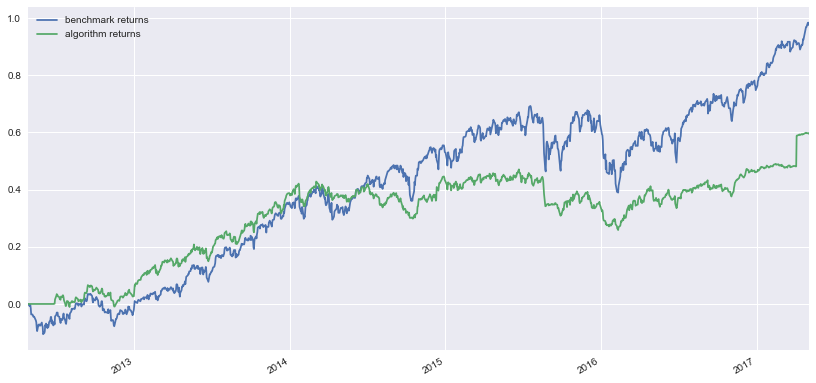

In [8]:
from abupy import AbuMetricsBase
metrics = AbuMetricsBase(*abu_result_tuple)
metrics.fit_metrics()
metrics.plot_returns_cmp(only_show_returns=True)

In [ ]:
abupy.env.g_enable_train_test_split = False
# 使用刚才切割股票池中的测试集symbols
abupy.env.g_enable_last_split_test = True
read_cash = 2000000
# g_atr_pos_base为0.015（因为切割训练集与测试集9:1，所以提高g_atr_pos_base为之前的10倍）
abupy.beta.atr.g_atr_pos_base = 0.015 
choice_symbols = None
abu_result_tuple_test, kl_pd_manager_test = abu.run_loop_back(read_cash, 
                  buy_factors, sell_factors, stock_pickers, choice_symbols=choice_symbols, n_folds=5)
# 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
abu.store_abu_result_tuple(abu_result_tuple_test, n_folds=5, store_type=EStoreAbu.E_STORE_TEST)

In [18]:
# 直接load模式
abu_result_tuple_test = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_TEST)

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_benchmark


买入后卖出的交易数量:8652
胜率:44.4406%
平均获利期望:10.9360%
平均亏损期望:-6.1797%
盈亏比:1.3414
策略收益: 71.3346%
基准收益: 98.3523%
策略年化收益: 14.2669%
基准年化收益: 19.6705%
策略买入成交比例:30.6504%
策略资金利用率比例:86.6122%
策略共执行1260个交易日


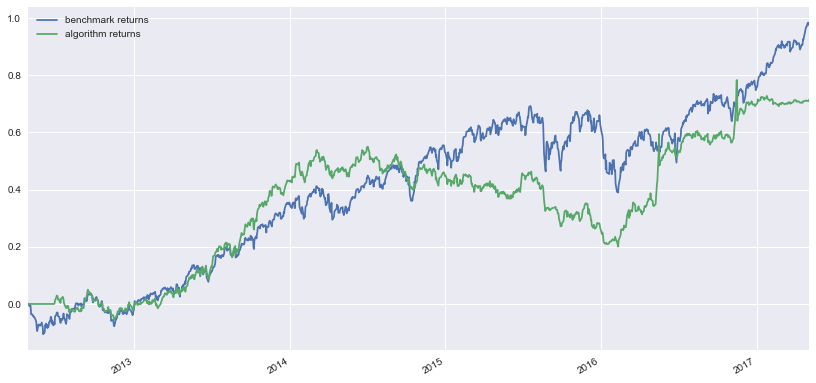

In [19]:
from abupy import AbuMetricsBase
metrics = AbuMetricsBase(*abu_result_tuple_test)
metrics.fit_metrics()
metrics.plot_returns_cmp(only_show_returns=True)

In [9]:
abu_result_tuple.orders_pd[abu_result_tuple.orders_pd.result != 0].head()

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,sell_type_extra,sell_date,sell_price,sell_type,...,wave_score2,wave_score3,jump_down_power,diff_down_days,jump_up_power,diff_up_days,atr_std,profit_cg,profit_cg_hunder,keep_days
2012-06-27,20120627,22.760,74,AbuFactorBuyBreak:42,usANTH,AbuAtrPosition,AbuFactorAtrNStop:stop_loss=1.0,20120629,5.824,loss,...,0.644,0.638,-13.687,106,1.425,68,0.739,-0.744110,-74.411010,2
2012-06-27,20120627,5.100,668,AbuFactorBuyBreak:42,usCLDX,AbuAtrPosition,AbuFactorCloseAtrNStop:close_atr_n=1.5,20120725,5.100,loss,...,-0.382,-0.331,-2.984,123,1.027,209,-0.143,0.000000,0.000000,28
2012-06-27,20120627,4.615,1116,AbuFactorBuyBreak:42,usCLFD,AbuAtrPosition,AbuFactorCloseAtrNStop:close_atr_n=1.5,20120713,4.985,win,...,-0.234,-0.179,-3.332,61,1.217,146,-0.123,0.080173,8.017335,16
2012-06-27,20120627,2.265,727,AbuFactorBuyBreak:42,usCSUN,AbuAtrPosition,AbuFactorAtrNStop:stop_loss=1.0,20120725,1.860,loss,...,0.363,0.210,-4.037,238,1.042,370,0.408,-0.178811,-17.881098,28
2012-06-27,20120627,20.550,282,AbuFactorBuyBreak:42,usCSS,AbuAtrPosition,AbuFactorAtrNStop:stop_loss=1.0,20120724,18.955,loss,...,-0.026,-0.059,-1.465,238,2.836,189,-0.208,-0.077616,-7.761557,27


### 10.5.2 基于特征的交易预测

In [10]:
from abupy import AbuUmpMainMul
mul = AbuUmpMainMul.UmpMulFiter(orders_pd=abu_result_tuple.orders_pd, scaler=False)
mul.df.head()

,result,deg_ang252,price_rank252,wave_score3,atr_std
2012-06-27,0,-35.994,0.274,0.638,0.739
2012-06-27,0,20.657,0.933,-0.331,-0.143
2012-06-27,1,-20.538,0.171,-0.179,-0.123
2012-06-27,0,2.189,0.897,0.210,0.408
2012-06-27,0,2.376,0.790,-0.059,-0.208


In [11]:
# 默认使用svm作为分类器
mul().cross_val_accuracy_score()

DecisionTreeClassifier score mean: 0.507025531793583


array([ 0.50147893,  0.50739463,  0.52008874,  0.49149618,  0.51331033,
        0.5019719 ,  0.50930605,  0.50807346,  0.49889053,  0.51824458])

In [12]:
# 分类器使用随机森林
mul().estimator.random_forest_classifier()
mul().cross_val_accuracy_score()

RandomForestClassifier score mean: 0.5200042621159869


array([ 0.51700764,  0.52415578,  0.5306877 ,  0.49864432,  0.51651467,
        0.5188563 ,  0.51842722,  0.52409713,  0.51799803,  0.53365385])

In [13]:
from abupy import AbuUmpMainDeg

deg = AbuUmpMainDeg.UmpDegFiter(orders_pd=abu_result_tuple.orders_pd)
# 分类器使用adaboost
deg().estimator.adaboost_classifier()
# 表10-8所示
deg.df.head()

,result,deg_ang21,deg_ang42,deg_ang60,deg_ang252
2012-06-27,0,20.810,20.123,10.881,-35.994
2012-06-27,0,7.607,4.116,-0.453,20.657
2012-06-27,1,4.911,1.140,-9.395,-20.538
2012-06-27,0,21.643,6.520,-5.124,2.189
2012-06-27,0,3.938,4.310,2.269,2.376


In [14]:
deg().cross_val_accuracy_score()

AdaBoostClassifier score mean: 0.5476865051406531


array([ 0.55016022,  0.53389204,  0.55163914,  0.54190288,  0.55336456,
        0.56236135,  0.53728584,  0.54677678,  0.54709073,  0.55239152])

In [15]:
deg().train_test_split_xy()

x-y:(81134, 4)-(81134,)
train_x-train_y:(73020, 4)-(73020,)
test_x-test_y:(8114, 4)-(8114,)
accuracy = 0.56
precision_score = 0.51
recall_score = 0.05
             precision    recall  f1-score   support

        0.0       0.56      0.96      0.71      4510
        1.0       0.51      0.05      0.10      3604

avg / total       0.54      0.56      0.44      8114



Confusion Matrix  [[4321  189]
 [3411  193]]
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 | 4321 | 189 |
Actual   |-----|-----|
       1 | 3411 | 193 |
         |-----|-----|


In [16]:
from abupy import AbuUmpMainFull

full = AbuUmpMainFull.UmpFullFiter(orders_pd=abu_result_tuple.orders_pd)
full().estimator.logistic_regression()
full.df.head()

,result,deg_ang21,deg_ang42,deg_ang60,deg_ang252,price_rank60,price_rank90,price_rank120,price_rank252,wave_score1,wave_score2,wave_score3,jump_down_power,diff_down_days,jump_up_power,diff_up_days,atr_std
2012-06-27,0,20.810,20.123,10.881,-35.994,1.000,0.767,0.575,0.274,0.524,0.644,0.638,-13.687,106,1.425,68,0.739
2012-06-27,0,7.607,4.116,-0.453,20.657,0.933,0.900,0.858,0.933,-0.273,-0.382,-0.331,-2.984,123,1.027,209,-0.143
2012-06-27,1,4.911,1.140,-9.395,-20.538,0.717,0.478,0.358,0.171,-0.203,-0.234,-0.179,-3.332,61,1.217,146,-0.123
2012-06-27,0,21.643,6.520,-5.124,2.189,1.000,0.900,0.825,0.897,0.441,0.363,0.210,-4.037,238,1.042,370,0.408
2012-06-27,0,3.938,4.310,2.269,2.376,0.992,0.950,0.738,0.790,0.062,-0.026,-0.059,-1.465,238,2.836,189,-0.208


In [17]:
full().cross_val_accuracy_score()

LogisticRegression score mean: 0.5466020207022537


array([ 0.5515159 ,  0.54486073,  0.55052995,  0.53623367,  0.54929751,
        0.55447375,  0.52471342,  0.54554419,  0.55436391,  0.55448718])

### 10.5.3 基于深度学习的交易预测

### 10.5.4 预测市场的混沌，混沌市场的预测